# San Francisco geographic crime report distribution

In [1]:
# load relevant libraries
library(ggplot2)
library(rgdal)
library(rgeos)
library(dplyr)
library(viridis)

# read in data, clean some column names
sf <- read.csv("sanfrancisco_incidents_summer_2014.csv")
sf$long <- sf$X
sf$lat <- sf$Y

# create a map from specific categories to 9 broad categories
cats <- list("ARSON" = "violent", 
"ASSAULT" = "violent", 
"BRIBERY" = "theft", 
"BURGLARY" = "theft", 
"DISORDERLY CONDUCT"  = "other", 
"DRIVING UNDER THE INFLUENCE"  = "substances", 
"DRUG/NARCOTIC"  = "substances", 
"DRUNKENNESS"  = "substances", 
"EMBEZZLEMENT"   = "theft", 
"EXTORTION"  = "theft", 
"FAMILY OFFENSES"  = "other", 
"FORGERY/COUNTERFEITING"  = "other", 
"FRAUD"  = "other", 
"GAMBLING"  = "other", 
"KIDNAPPING"  = "violent", 
"LARCENY/THEFT"  = "theft", 
"LIQUOR LAWS"  = "substances", 
"LOITERING"  = "other", 
"MISSING PERSON" = "missing person", 
"NON-CRIMINAL"  = "noncriminal", 
"OTHER OFFENSES"  = "other", 
"PORNOGRAPHY/OBSCENE MAT"  = "other", 
"PROSTITUTION"  = "other",
"ROBBERY"  = "theft", 
"RUNAWAY"  = "other", 
"SECONDARY CODES"  = "other", 
"STOLEN PROPERTY"  = "theft", 
"SUICIDE"  = "other", 
"SUSPICIOUS OCC"  = "suspicious occurance", 
"TRESPASS"  = "other", 
"VANDALISM"  = "other", 
"VEHICLE THEFT"  = "theft", 
"WARRANTS" = "warrants", 
"WEAPON LAWS" = "weapons")

sf$broadCategories <- as.factor(unlist(cats[sf$Category]))
  
# read in zip code boundary information from https://data.sfgov.org/Geographic-Locations-and-Boundaries/San-Francisco-ZIP-Codes-Zipped-Shapefile-Format-/9q84-kc2y
sfzips <- readOGR("sfzipcodes/","sfzipcodes") %>% spTransform(CRS("+proj=longlat +datum=WGS84"))
# sfneighborhoods <- readOGR("planning_neighborhoods/","planning_neighborhoods") %>% spTransform(CRS("+proj=longlat +datum=WGS84"))

# create a spatial frame from the crime data
sfCrimes <- sf
coordinates(sfCrimes) <- c("long", "lat")

# match the coordinate systems
proj4string(sfCrimes) <- proj4string(sfzips)

# generate a vector for which zip each crime happend in.
zipIn <- over(sfCrimes, as(sfzips, "SpatialPolygons"))

# assign each crime to a zip code based on lattitude and longitude
zipInfoForCrimes <- over(sfCrimes, sfzips)
# join zips to the crimes
sf <- cbind(sf, zipInfoForCrimes)
# remove the crimes that are not within a zipcode (in this set there are about 84 of those, most are just beyond the city boundary)
sf <- subset(sf, !is.na(ZIP_CODE))

# convert spatial data to a dataframe for easier plotting
zipData <- fortify(sfzips)
sfzips@data$id <- rownames(sfzips@data)
zipData <- merge(zipData, sfzips@data, by="id")

# create centroid labels
zipLabels <- zipData %>% group_by(ZIP_CODE) %>% summarise(long = mean(range(long)), lat = mean(range(lat)))

Loading required package: sp
rgdal: version: 1.0-4, (SVN revision 548)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.2, released 2015/02/10
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rgdal/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.1, 04 March 2015, [PJ_VERSION: 491]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rgdal/proj
 Linking to sp version: 1.1-1 
rgeos version: 0.3-11, (SVN revision 479)
 GEOS runtime version: 3.4.2-CAPI-1.8.2 r3921 
 Linking to sp version: 1.1-0 
 Polygon checking: TRUE 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:rgeos’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:twitteR’:

    id, location

The following objects are masked from ‘package:base’:

    intersect, setdiff, seteq

OGR data source with driver: ESRI Shapefile 
Source: "sfzipcodes/", layer: "sfzipcodes"
with 25 features
It has 3 fields


Regions defined for each Polygons


## Primary finding

Crime reports are not evenly distributed across the city of San Francisco. This distribution is not even with respect to geography, population density, or crime report type. The areas around the Hayes Valley, Tenderloin, North and South of Market, Mission, and Bernal Heights neighborhoods have more crime reports than many other parts of the city. This is true even though those areas are not the most populated areas in the city (that is, they have high per capite crime report rates). Finally, the types of crime reports are not evenly distributed across the city. There are more substance-related crime reports around the Hayes Valley, Tenderloin, and North of Market neighborhoods than in other parts of the city and there are more theft-related crime reports around the South of Market neighborhood than other parts of the city.

## Supporting materials

First, this figure is a key to the zip codes for the city of San Francisco.

ERROR: Error in file(con, "rb"): cannot open the connection


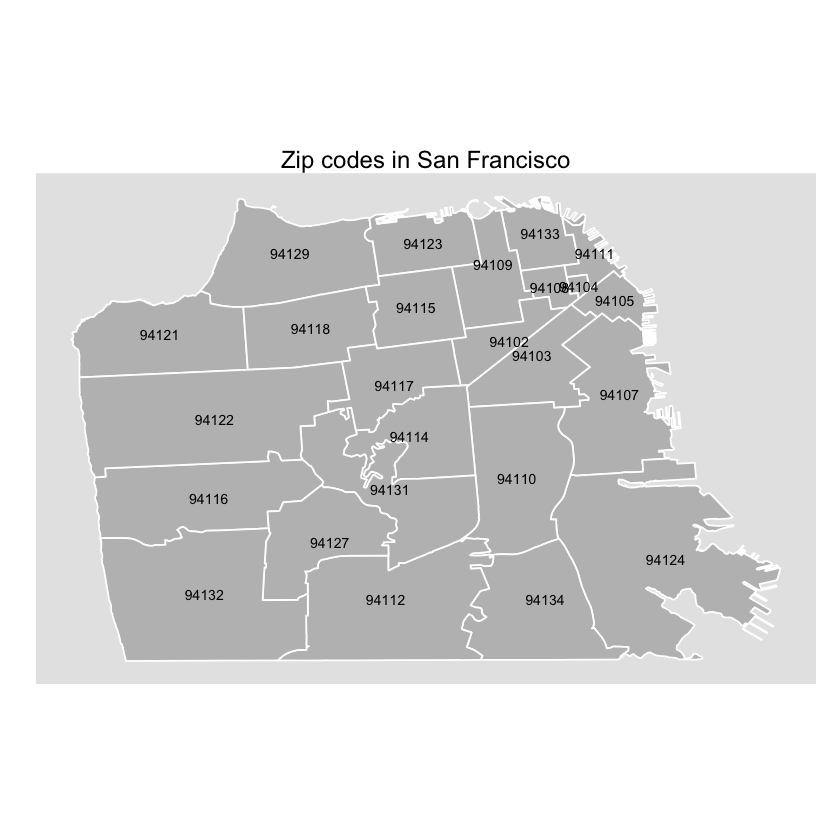

In [2]:
# Key
ggplot() + 
  geom_polygon(data = zipData, aes(x = long, y = lat, group = group), fill = "grey", color = "white") + 
  geom_text(data = zipLabels, aes(x = long, y = lat, label = ZIP_CODE), size =3) +
  coord_fixed() + 
  theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank()) +
  labs(title="Zip codes in San Francisco")

## Overall geographic distribution of crime reports

It is clear that crime reports are not evenly distributed across the city. There is a large concentration of reports in zip codes 94102, 94103, 94108, 94109, and 94110. This area includes the Hayes Valley, Tenderloin, North and South of Market, Mission, and Bernal Heights neighborhoods. Other zip codes see relatively less crime.

The following figure has each crime report overlayed on a map of San Francisco divided by zip codes. Each dot represents one crime report, and it is plotted based on the Latitude and Longitude information from the police report (so it is only as good as those reports). Individual dots are transparent in order to show the density of crime reports in areas where there are more reports better.

ERROR: Error in file(con, "rb"): cannot open the connection


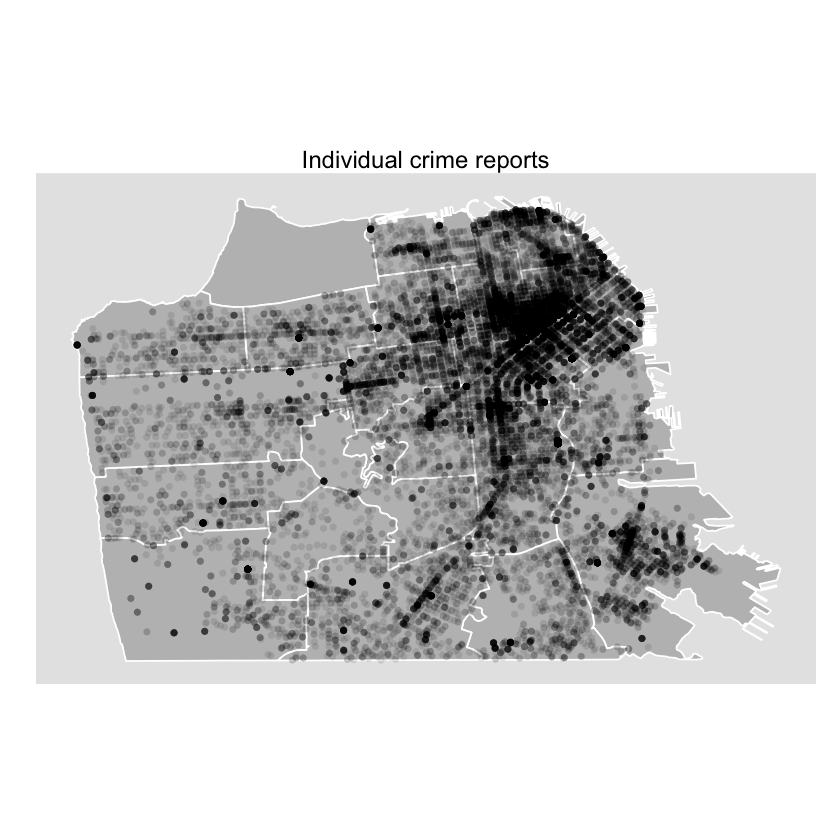

In [3]:
# Where is the crime?
crimeCounts <- sf %>% group_by(ZIP_CODE) %>% summarize(count = length(IncidntNum))
crimeCounts$id <- crimeCounts$zip

mergedZip <- merge(zipData, crimeCounts, by="ZIP_CODE")

ggplot() + 
  geom_polygon(data = zipData, aes(x = long, y = lat, group = group), fill="grey", color = "white")  +
  geom_point(data = sf, aes(x = long, y = lat), alpha = 0.1) +
  coord_fixed() + 
  theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank()) +
  labs(title="Individual crime reports")

This next plot takes each report and assigns it to the zip code where it occurred. Nearly all crime reports fell into one of the city's zip codes (a tiny fraction were reports from just outside the city, or on Treasure Island, which are not included here). This figure shows the total count of crime reports for each zip code. Blues have fewer reports, and yellows have more reports. Zip codes 94102, 94103, and 94110 really stand out as having a much larger number of crimes in their areas.


ERROR: Error in file(con, "rb"): cannot open the connection


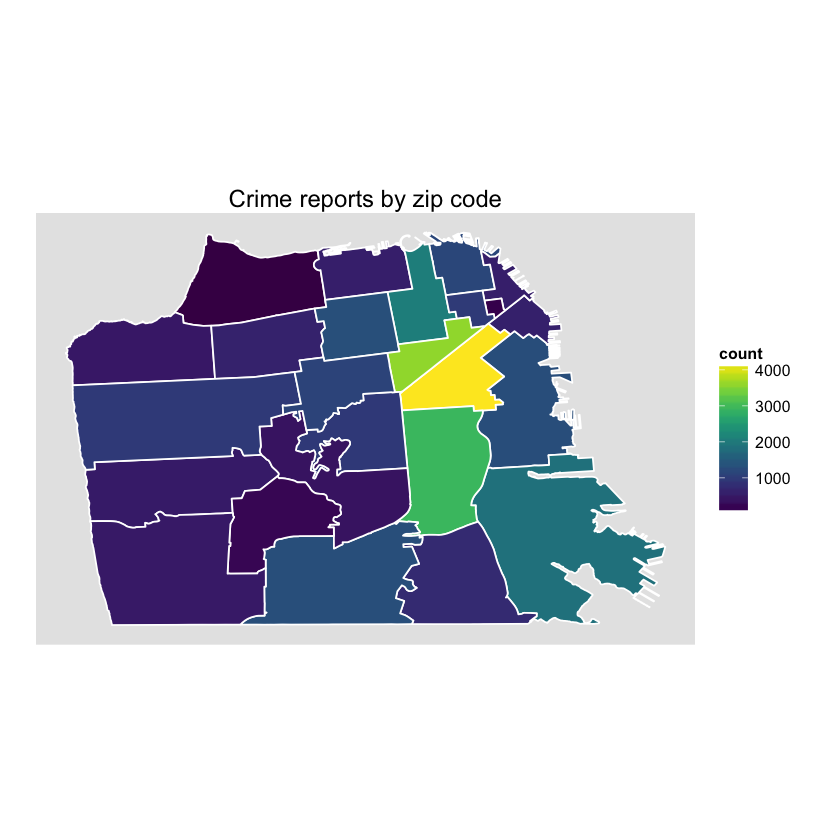

In [4]:
ggplot() + 
  geom_polygon(data = mergedZip, aes(x = long, y = lat, group = group, fill=count), color = "white") + 
  scale_fill_viridis() + 
  coord_fixed() + 
  theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank()) +
  labs(title="Crime reports by zip code")


## Crime reports and population density

One possible explanation for this pattern is that there could be more crime reports in areas with more people. At first, we might expect that crime reports increase as the population increases. But, as the two figures below show, that relationship does not hold for San Francisco.

The figure below shows the total population for each zip code from the 2010 census. Again, blues mean less population, and yellows mean more. We can see here that the zip codes that had the most crime reports above do not stand out as having the most population as well.

ERROR: Error in file(con, "rb"): cannot open the connection


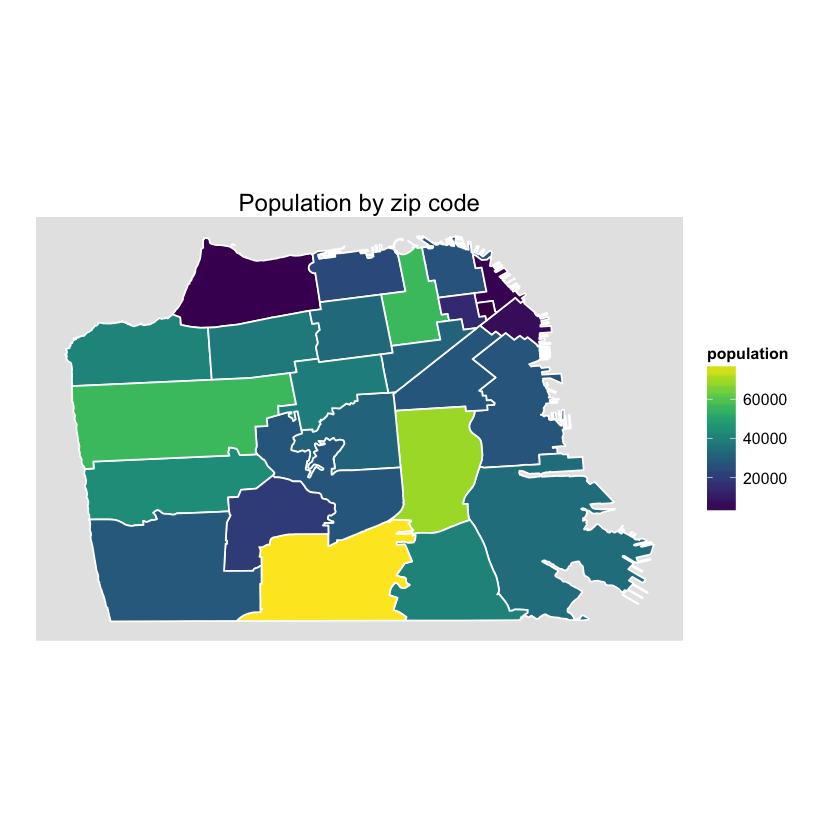

In [5]:
# crimes per capita
pop <- read.csv("DEC_10_SF1_P1_with_ann.csv")
pop$ZIP_CODE <- pop$Id2
pop$population <- pop$Total
pop <- select(pop, ZIP_CODE, population)

crimeCounts <- sf %>% group_by(ZIP_CODE) %>% summarize(count = length(IncidntNum))
crimeCounts$id <- crimeCounts$ZIP_CODE
crimeCounts <- merge(crimeCounts, pop)
crimeCounts$crimePerCapita <- crimeCounts$count/crimeCounts$pop
  
mergedZip <- merge(zipData, crimeCounts, by="ZIP_CODE")

ggplot() + 
  geom_polygon(data = mergedZip, aes(x = long, y = lat, group = group, fill=population), color = "white") + 
  scale_fill_viridis() + 
  coord_fixed() + 
  theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank()) +
  labs(title="Population by zip code")

This figure takes the total number of crime reports in each zip code and divides it by the population that lives there. This allows us to see relative differences in crime reports between zip codes, while taking into account the fact that there are more people in some zip codes than in others. The first thing that stands out is that 94104 and 94111 have the highest crime reports per capita. These zip codes include the Financial District, where very few people live (which can be seen in the figure above as well), but many people work. Because we defined population based on where people live, the population of these zip codes will be low, even though there are many people there during the day for work. This low population is one cause of the high per capita rate of crime reports in these two zip codes.

Additionally, two other zip codes stand out as having high crime reports per capita, while having mid-ranged populations: 94102 and 94103. This zip codes include the Hayes Valley, Tenderloin, as well as the North and South of Market neighborhoods. Most other zip codes have a relatively even distribution of per capita crime reports.

ERROR: Error in file(con, "rb"): cannot open the connection


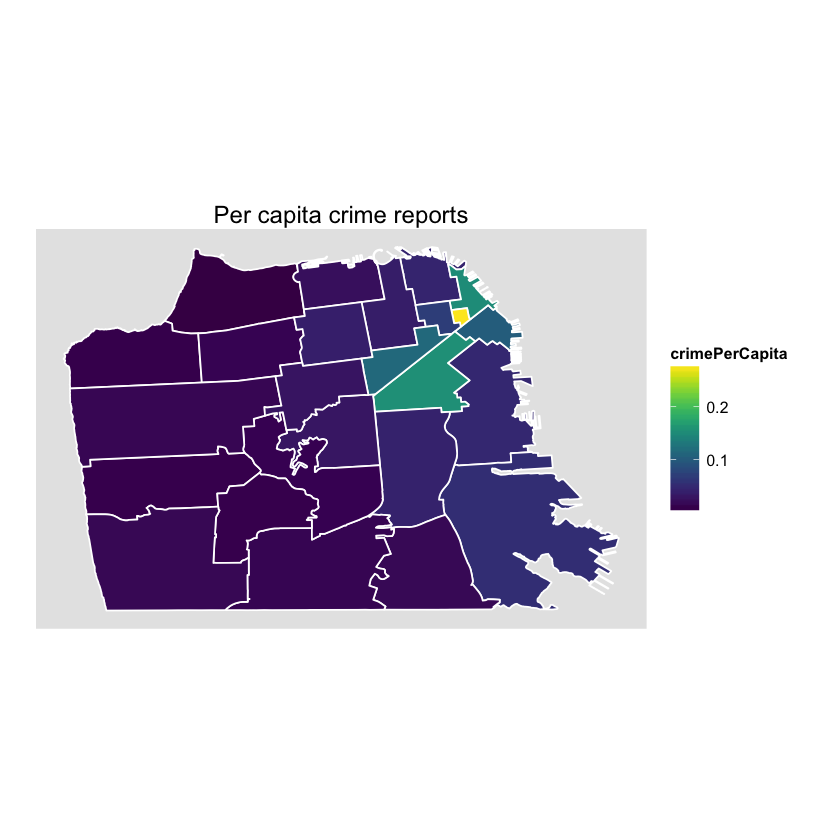

In [6]:
ggplot() + 
  geom_polygon(data = mergedZip, aes(x = long, y = lat, group = group, fill=crimePerCapita), color = "white") + 
  scale_fill_viridis() + 
  coord_fixed() + 
  theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank()) +
  labs(title="Per capita crime reports")

## Distribution of types of crime reports

Finally, the types of crimes committed vary tremendously based on geography. The original data had over 20 categories of reports, but here I've collapsed those down into 9 broad categories. Most category labels are descriptive, but a few are not: noncriminal generally contains traffic citations; substances includes any drug-related offence as well as public intoxication; suspicious occurrence seems to be a catch all for any general stop made without specific cause.

The figure below has each crime report overlayed on the map of San Francisco zip codes, further broken down by crime report type. We can see that that theft reports are reported throughout the city, and are by far the most common type of report. Substance reports are more concentrated around the zip codes 94102 and 94103.

ERROR: Error in file(con, "rb"): cannot open the connection


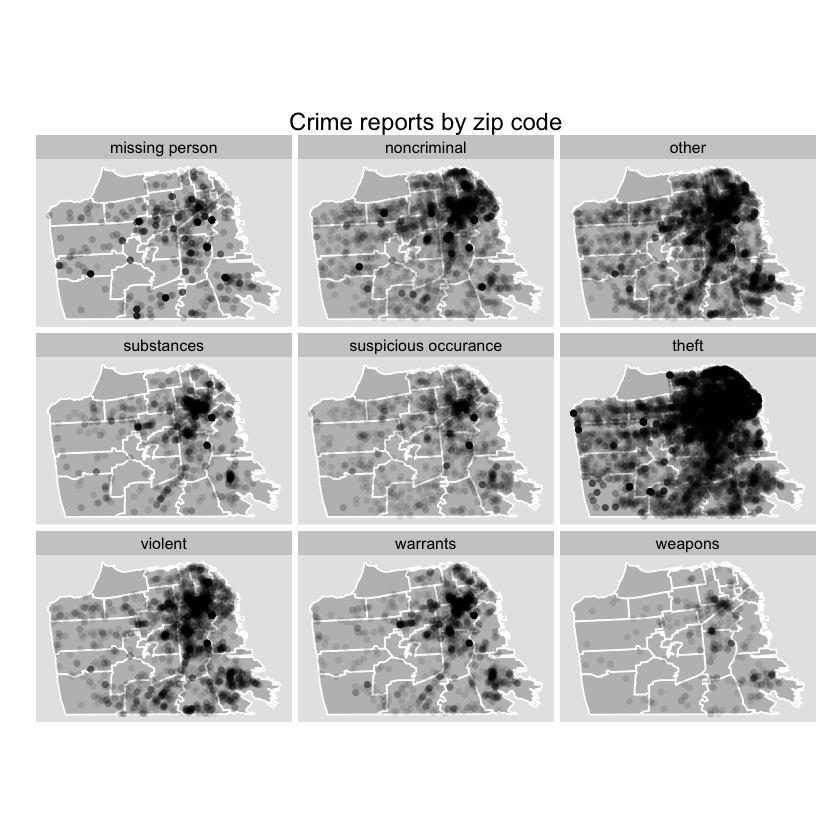

In [7]:
#### What kinds of crime
ggplot() + 
  geom_polygon(data = zipData, aes(x = long, y = lat, group = group), fill="grey", color = "white")  +
  geom_point(data = sf, aes(x = long, y = lat), alpha = 0.1) +
  facet_wrap(~broadCategories) + 
  coord_fixed() + 
  theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank()) +
  labs(title="Crime reports by zip code")

We know how frequently crime reports of each type happen, so we can now look to see if the distribution of crime report types is even throughout the city, or if specific types of reports happen in specific zip codes. We've already seen that crime reports are not evenly distributed through out the city. Since we know the distribution of crimes by zip code, we can use that information to make sure we are looking at the variation of crime reports by type only, correcting for the overall number of crimes within a zip code. To do this, we took the frequency of all crime reports in each zip code, combined that with the frequency of each crime report type from the whole city to come up with an expected crime count for each crime report type in each zip code if there was no variation in the types of crime based on zip code. To make this concrete: zip code 94102 has 12.39% of the crime reports for the entire city. Substance reports are 5.65% of all crime reports. There were 28993 crime reports overall, so we expect that if crime report types were evenly distributed within each county, zip code 94102 would have 0.1239 * 0.0565 * 28993 = 203 substance-related crime reports. What we actually find is that zip code 94102 has 445 substance-related crime reports, which is more than double what we could expect if crime report types were distributed evenly across the city.

The following figure shows the difference between the number of crime reports, broken down by type, between the actual count of crime reports and how many reports we expect if crime report types were evenly distributed throughout the city. What is striking is that there is a high concentration of substance-related crime reports in  zip code 94102 compared with the rest of the city. Additionally, for theft crime reports, there are more in zip code 94103 than we would expect, but fewer than we would expect in the zip codes 94102, 94110, and 94124.

Joining by: jn


ERROR: Error in file(con, "rb"): cannot open the connection


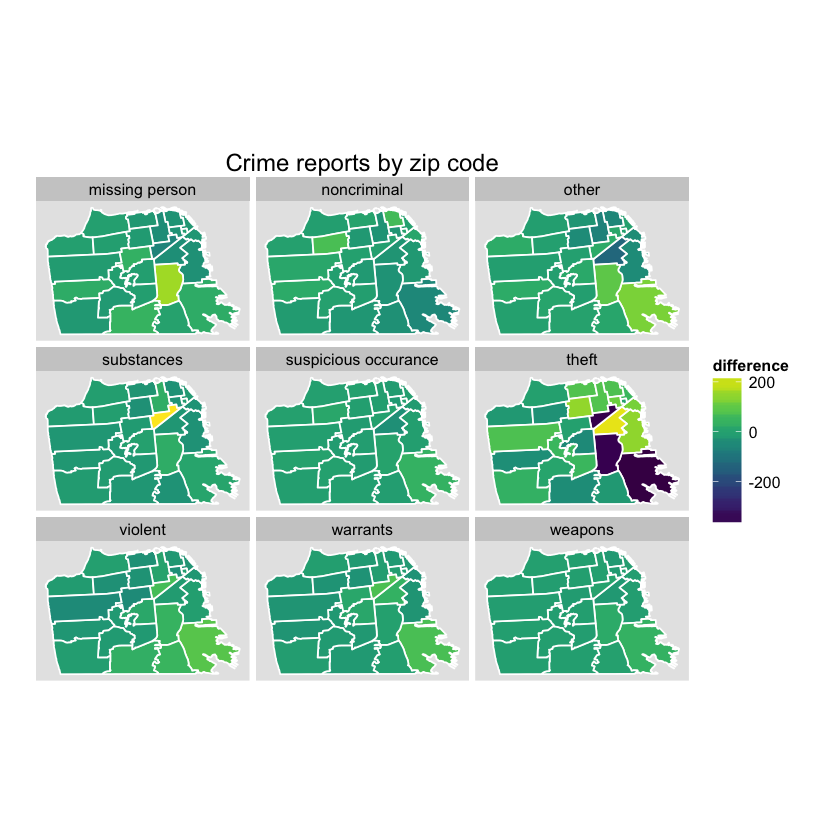

In [8]:
# which zips contribute the most crime?
crimeCounts <- sf %>% group_by(ZIP_CODE, broadCategories) %>% summarize(count = length(IncidntNum))
crimesInZipz <- crimeCounts %>% group_by(ZIP_CODE) %>% summarise(totInZip = sum(count)) %>% mutate(percZip = totInZip / sum(totInZip), jn = 1)
crimesInCats <- crimeCounts %>% group_by(broadCategories) %>% summarise(totInCat = sum(count)) %>% mutate(percCat = totInCat / sum(totInCat), jn = 1)

proportions <- select(plyr::join(crimesInZipz, crimesInCats, type="full"), ZIP_CODE, broadCategories, percZip, percCat)
proportions$expectedN <- nrow(sf)*proportions$percZip*proportions$percCat

crimeCountsWithExpected <- merge(crimeCounts, proportions, all = TRUE)
crimeCountsWithExpected$count <- ifelse(is.na(crimeCountsWithExpected$count), 0, crimeCountsWithExpected$count)

crimeCountsWithExpected$diff <- crimeCountsWithExpected$count - crimeCountsWithExpected$expectedN

crimeCountsWithExpected$id <- crimeCountsWithExpected$zip

mergedZip <- merge(zipData, crimeCountsWithExpected, by="ZIP_CODE")

ggplot() + 
  geom_polygon(data = mergedZip, aes(x = long, y = lat, group = group, fill=diff), color = "white") + 
  facet_wrap(~broadCategories) + 
  scale_fill_viridis("difference") + 
  coord_fixed() + 
  theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank()) +
  labs(title="Crime reports by zip code")